# Download Lidar Tilesets and Perform MR classifcation

In [1]:
import src.modules.utils as util

In [2]:
# Download Las File to hard disk
las_fileID = 25192
year = 2017

Filename = str(las_fileID)+'.las'
External_Disk_Path = '/Volumes/Elements/Terravide/Datasets/FTP_files/LiDAR/'
util.FTP_download_lasfile(Filename,year,folderpath=External_Disk_Path)

"""TODO 
Iterate and download all ftp file

# Use below code snippet as referance 
filenames = ftp.nlst() # get filenames within the directory
print filenames

for filename in filenames:
    local_filename = os.path.join('C:\\test\\', filename)
    file = open(local_filename, 'wb')
    ftp.retrbinary('RETR '+ filename, file.write)

    file.close()

ftp.quit() # This is the “polite” way to close a connection

"""

[UTIL] Function - Datayear :  2017
File Exists


"TODO \nIterate and download all ftp file\n\n# Use below code snippet as referance \nfilenames = ftp.nlst() # get filenames within the directory\nprint filenames\n\nfor filename in filenames:\n    local_filename = os.path.join('C:\\test\\', filename)\n    file = open(local_filename, 'wb')\n    ftp.retrbinary('RETR '+ filename, file.write)\n\n    file.close()\n\nftp.quit() # This is the “polite” way to close a connection\n\n"

In [3]:
import src.modules.MultipleReturnsClassification as MRC
import time
import pptk
import numpy as np
import seaborn as sns 

In [4]:
#User Defines (Also in Utils)

def View3Dpoints(points, color=[[1,0,0]]):
    """Calls PPTK with basic config to plot 3d points

    Args:
        points (Nx3 Numpy Array): NX3 numpy array
    """
    exitViewerFlag = False
    while not exitViewerFlag:
        v = pptk.viewer(points, color*len(points))
        v.set(show_grid=False)
        v.set(show_axis=False)
        v.set(bg_color = [0,0,0,0])
        v.set(point_size = 0.0004)
        exitViewerFlag = int(input("Enter a 1 to exit viewer : "))

    v.close()

    return None

In [5]:
#Object to handle las preprocessing
LasHandling = MRC.LFP

#record start time of script
script_start = time.time()


TileDivision = 12
rows, cols = (TileDivision, TileDivision)


lasfilepath = External_Disk_Path+'NYC_'+str(year)+'/'+str(las_fileID)+'.las'

#Read las file
lasfile_object = LasHandling.Read_lasFile(lasfilepath)

#Create Dataframe from lasfile
lidar_df, rawpoints = LasHandling.Create_lasFileDataframe(lasfileObject=lasfile_object)

#Divide lidar_df into smaller portion for development
portion_size = 100 # 1-100 %
lidar_df = lidar_df.head(int(len(lidar_df)*(portion_size/100)))

#sanity check
pptk.viewer(lidar_df.iloc[:,:3].to_numpy())

# Implementing a Z limit

In [ ]:
# Tree_Height_Limit = 80 # in m
# lidar_df_ZLimited  = lidar_df[lidar_df.Z < Tree_Height_Limit]

# lidar_df = lidar_df_ZLimited
# pptk.viewer(lidar_df.iloc[:,:3].to_numpy())

In [6]:
#Extract MR and SR points from Dataframe
MR_df = LasHandling.Get_MRpoints(lidar_df)
SR_df = LasHandling.Get_SRpoints(lidar_df)

#lasTile class
TileObj_SR = MRC.MR_class(SR_df,TileDivision) #Single Return Points
TileObj_MR = MRC.MR_class(MR_df,TileDivision) #Multiple Return Points

#Serialized Creation of Lidar Subtiles
lidar_TilesubsetArr = TileObj_MR.Get_subtileArray()

# type(lidar_TilesubsetArr[0][0]) -> pandas.core.frame.DataFrame
# [[0]*self.cols for _ in range(self.rows)]

#---------------------------------------------------------------------

# #sanity check
# temp_segmentPoints = lidar_TilesubsetArr[1][0].iloc[:,:3].to_numpy()
# pptk.viewer(temp_segmentPoints)

# #MR points plot
# pptk.viewer(MR_df.iloc[:,:3].to_numpy())

# #SR points plot
# pptk.viewer(SR_df.iloc[:,:3].to_numpy())

# Get Approximate Location of tile

In [7]:
#Print Lat , Long
ix, iy = np.mean(MR_df.X.to_numpy()), np.mean(MR_df.Y.to_numpy()) 

from pyproj import Transformer

transformer = Transformer.from_crs("epsg:2263", "epsg:4326")
lat, lon = transformer.transform(ix*3.28, iy*3.28)
print(str(lat)+","+str(lon))

40.69963574170024,-73.84812319726677


## Tuning Hyperparameters

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# from mpl_toolkits.mplot3d import Axes3D
# from sklearn.cluster import DBSCAN

# from sklearn.cluster import DBSCAN
# from sklearn.metrics import silhouette_score # How best can we seperate clusters

# from scipy.stats import ks_2samp #Check how different each distributions are

In [9]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

def Get_eps_NN_KneeMethod(cluster_df, N_neighbors = 12, display_plot=False):

    nearest_neighbors = NearestNeighbors(n_neighbors=N_neighbors)
    neighbors = nearest_neighbors.fit(cluster_df)
    distances, indices = neighbors.kneighbors(cluster_df)
    distances = np.sort(distances[:,N_neighbors-1], axis=0)

    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    if (display_plot):
        fig = plt.figure(figsize=(5, 5))
        knee.plot_knee()
        plt.xlabel("Points")
        plt.ylabel("Distance")
        print(distances[knee.knee])
    
    return distances[knee.knee]

# def Get_Optimal_MinSamples(points,ep,start=20,end=70,step=10):

#     range_min_samples = np.arange(start, end, step)

#     S_score_min_samples_hashmap = {} # S_score -> min_samples

#     for m in range_min_samples :
                
#         db = DBSCAN(eps=ep, min_samples=m).fit(points)
#         core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#         core_samples_mask[db.core_sample_indices_] = True
#         labels = db.labels_
#         #print(set(labels))
#         if(len(set(labels))) < 2 :
#              return (1.5,0)
#         silhouette_avg = silhouette_score(points, labels)
#         print("For eps value = ",ep,"; Min Samples = ",m, "The average silhouette_score is :", silhouette_avg)

#         if silhouette_avg not in S_score_min_samples_hashmap:
#             S_score_min_samples_hashmap[silhouette_avg] = ep
        
#         Best_min_samples = S_score_min_samples_hashmap[max(S_score_min_samples_hashmap)]
    
#     return (Best_min_samples, max(S_score_min_samples_hashmap))

In [10]:
def Normalize_points(points):
    return points / np.linalg.norm(points)

In [11]:
# # finding optimal min_samples
# range_min_samples = np.arange(10, 60, 10)
# ep = distances[knee.knee]

# points = cluster_df.to_numpy()

# for m in range_min_samples :

#         print(ep,m)
                
#         db = DBSCAN(eps=ep, min_samples=m).fit(points)
#         core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#         core_samples_mask[db.core_sample_indices_] = True
#         labels = db.labels_
        
#         silhouette_avg = silhouette_score(points, labels)
#         print("For eps value = ",ep, "The average silhouette_score is :", silhouette_avg)

# Plot EPS variations on tile

EPS :  1.5616137801635426


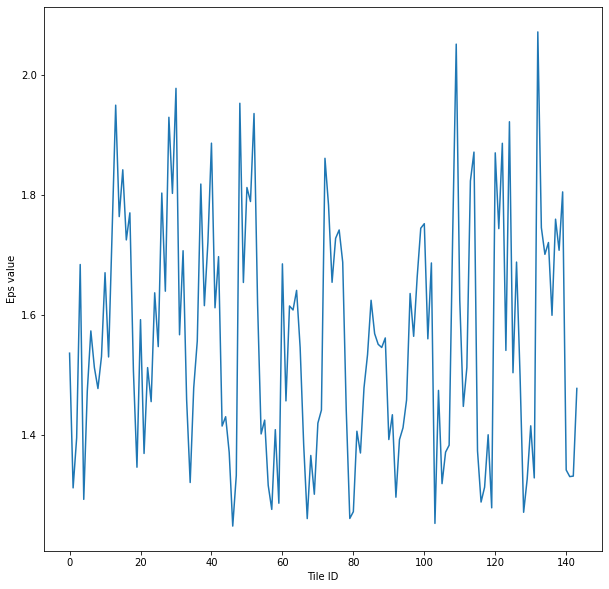

In [12]:
All_eps = [] #Stores all eps values by tile id

for row in range(TileDivision):
    for col in range(TileDivision):

        cluster_df = lidar_TilesubsetArr[row][col].iloc[:,:3]

        tile_eps = Get_eps_NN_KneeMethod(cluster_df)

        All_eps.append(tile_eps)

fig = plt.figure(figsize=(10, 10))
plt.plot(All_eps)
plt.xlabel("Tile ID")
plt.ylabel("Eps value")

Optimal_EPS = np.mean(All_eps)
print("EPS : ",Optimal_EPS)


In [25]:
Tilecounter = 0
Trees_Buffer = []

for row in range(6,TileDivision):
    for col in range(10,TileDivision):

        print('-'*40)
        
        print("TILE ID : ",Tilecounter)
        Tilecounter = Tilecounter + 1

        # cluster_df = lidar_TilesubsetArr[row][col].iloc[:,:3]

        # tile_eps = Optimal_EPS #Get_eps_NN_KneeMethod(cluster_df)

        tile_segment_points = lidar_TilesubsetArr[row][col].iloc[:,:3].to_numpy()

        subTileTree_Points,  _ = TileObj_MR.Classify_MultipleReturns(tile_segment_points)

        for t in subTileTree_Points:
            Trees_Buffer.append(t)
        
        print("Trees added")

Trees_Buffer = np.array(Trees_Buffer)

pptk.viewer(Trees_Buffer)

----------------------------------------
TILE ID :  0
Trees added
----------------------------------------
TILE ID :  1
Trees added
----------------------------------------
TILE ID :  2
Trees added
----------------------------------------
TILE ID :  3
Trees added
----------------------------------------
TILE ID :  4
Trees added
----------------------------------------
TILE ID :  5
Trees added
----------------------------------------
TILE ID :  6
Trees added
----------------------------------------
TILE ID :  7
Trees added
----------------------------------------
TILE ID :  8
Trees added
----------------------------------------
TILE ID :  9
Trees added
----------------------------------------
TILE ID :  10
Trees added
----------------------------------------
TILE ID :  11
Trees added


In [31]:
p = lidar_TilesubsetArr[6][10].iloc[:,:3].to_numpy()
t , _ = TileObj_MR.Classify_MultipleReturns(tile_segment_points,hp_eps=1.4)

In [32]:
pptk.viewer(t)

# Below block maps distribution to hyperparameter - Maybe not needed

In [ ]:
# Tilecounter = 0
# Trees_Buffer = []

# # Hashmap to store MinSamples with distribution
# MinSamples_Distribution_Hmap = {} # Df_Z -> MinSamples

# for row in range(2):
#     for col in range(4):

#         print('-'*40)
        
#         print("TILE ID : ",Tilecounter)
#         Tilecounter = Tilecounter + 1

#         cluster_df = lidar_TilesubsetArr[row][col].iloc[:,:3]

#         tile_eps = Get_Optimal_Eps(cluster_df)

#         tile_segment_points = cluster_df.to_numpy()

#         # tile_segment_points_X = lidar_TilesubsetArr[row][col].iloc[:,0].to_numpy()
#         # tile_segment_points_Y = lidar_TilesubsetArr[row][col].iloc[:,1].to_numpy()
#         # tile_segment_points_Z = lidar_TilesubsetArr[row][col].iloc[:,2].to_numpy()
        
#         if (len(tile_segment_points) > 0): #buffer has points to classify

#             if not MinSamples_Distribution_Hmap: #Dict is empty
                
#                 #find optimal MinSamples
#                 Optimal_MinSamples, S_Score = Get_Optimal_MinSamples(points=tile_segment_points, ep=tile_eps)

#                 # Mapping Z distribution -> MinSamples value,  to check KS_statistic later to compare distribution
#                 MinSamples_Distribution_Hmap[tuple(tile_segment_points[:,2])] = [Optimal_MinSamples,S_Score]
            
#             else: #Dict is not empty

#                 #Find Minimum KS statistic and check is KS statistic is less than 0.5 (arbitarily chosen)

#                 KS_stat_list = [] # Empty list for each tile to compare KS statistic as seen from previous tiles
#                 min_KS_stat_info = [100,-1] #[KS_stat, Key of dict after comparison] #default 100,-1

#                 for k in MinSamples_Distribution_Hmap.keys() : 

#                     z1 = Normalize_points(k) # get Z_points from dict
#                     z2 = Normalize_points(tile_segment_points[:,2]) # get Z_points from new tile

#                     cur_statistic, pvalue = ks_2samp(z1, z2) #compare

#                     #Logs
#                     # print(f'K-S statistic (z): {cur_statistic:.3f}')
#                     # print(f'p-value (z): {pvalue:.3f}')

#                     #if pvalue < 0.05: #p < 0.05 , # NOTE: Not sure to include, maybe identical buildings?
#                     KS_stat_list.append(cur_statistic) #add to list

#                     if cur_statistic < min_KS_stat_info[0]:
#                         #update best distribution
#                         min_KS_stat_info[0] = cur_statistic
#                         min_KS_stat_info[1] = k
                
#                 print("KS Stat : ",min_KS_stat_info[0])

#                 #NOTE : #if KS_statistic is significant (high) it represents that the 2 disttribtuions are very Different and likely drawn from different distributions

#                 if min_KS_stat_info[0] < 0.6: 

#                     #get optimal MinSamples from best matching distribution

#                     Optimal_MinSamples, S_Score = MinSamples_Distribution_Hmap[min_KS_stat_info[1]] #Get the optimal MinSamples and s_score by passing key (df_z values) of best match (low KS)
#                 else:

#                     #Recalculate MinSamples and add it to hashmap 

#                     #find optimal MinSamples
#                     Optimal_MinSamples, S_Score = Get_Optimal_MinSamples(tile_segment_points)

#                     # Mapping Z distribution -> MinSamples value,  to check KS_statistic later to compare distribution
#                     MinSamples_Distribution_Hmap[tuple(tile_segment_points[:,2])] = [Optimal_MinSamples,S_Score]
                       
#             # Logs
#             print("OPTIMAL MinSamples : ",Optimal_MinSamples)
            

#             subTileTree_Points,  _ = TileObj_MR.Classify_MultipleReturns(tile_segment_points, hp_eps=tile_eps, hp_min_points=Optimal_MinSamples)

#             for t in subTileTree_Points:
#                 Trees_Buffer.append(t)
            
#             print("Trees added")

# Trees_Buffer = np.array(Trees_Buffer)

# pptk.viewer(Trees_Buffer)

In [ ]:
#plotting inlier and outlier
p1 = Trees_Buffer
p2 = MR_df.iloc[:,:3].to_numpy()
All_points_1 = np.concatenate((p1, p2), axis=0)
rgb_p2 =  [[1,0,0]]*len(p2) #Set red colour
rgb_p1 = [[0,1,0]]*len(p1) #set green colour
All_rgb = np.concatenate((rgb_p1, rgb_p2,), axis=0)

#Red - Inlier - ground plane , Green - Outlier
v = pptk.viewer(All_points_1, All_rgb)
v.set(show_grid=False)
v.set(show_axis=False)
v.set(bg_color = [0,0,0,0])
v.set(point_size = 0.04)

In [ ]:
pptk.viewer(Trees_Buffer)

In [ ]:
pptk.viewer(MR_df.iloc[:,:3].to_numpy())

In [ ]:
for k in EPS_Distribution_Hmap.keys() : 

    z1 = Normalize_points(EPS_Distribution_Hmap[k]) # get Z_points from dict
    print(z1)

In [ ]:
hmap_Keys = EPS_Distribution_Hmap.keys()

for k in range(len(hmap_Keys)):
    print(k)
    print(len(hmap_Keys[k]))

    z1 = Normalize_points(EPS_Distribution_Hmap[hmap_Keys[k]]) # get Z_points from dict

In [ ]:
t1 = Normalize_points(lidar_TilesubsetArr[0][0].iloc[:,:3].to_numpy())
t2 = Normalize_points(lidar_TilesubsetArr[0][1].iloc[:,:3].to_numpy())

In [ ]:
sns.jointplot(t1[:,0], t1[:,1], kind='scatter')

In [ ]:
from scipy.stats import ks_2samp


# Extract the x and y coordinates from the point cloud datasets
x1 = t1[:,0]
y1 = t1[:,1]
z1 = t1[:,2]
x2 = t2[:,0]
y2 = t2[:,1]
z2 = t2[:,2]

# Perform the K-S test on the x coordinates
statistic, pvalue = ks_2samp(x1, x2)
print(f'K-S statistic (x): {statistic:.3f}')
print(f'p-value (x): {pvalue:.3f}')

# Perform the K-S test on the y coordinates
statistic, pvalue = ks_2samp(y1, y2)
print(f'K-S statistic (y): {statistic:.3f}')
print(f'p-value (y): {pvalue:.3f}')


#NOTE : Z value varies the most, if KS is large , there are from different distributions
# Perform the K-S test on the z coordinates
statistic, pvalue = ks_2samp(z1, z2)
print(f'K-S statistic (z): {statistic:.3f}')
print(f'p-value (z): {pvalue:.3f}')

In [ ]:
import matplotlib.pyplot as plt

z1 = norm1[:,2]
z2 = norm2[:,2]

# Set up the figure and axes for the histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Plot the histogram for the z1 norm1
ax1.hist(z1, bins=20)
ax1.set_xlabel('z1')
ax1.set_ylabel('count')

# Plot the histogram for the z2 norm2
ax2.hist(z2, bins=20)
ax2.set_xlabel('z2')
ax2.set_ylabel('count')


# Show the figure
plt.show()
